# Visualizations of Reporting Delay and Case Counts

## Imports

In [2]:
import pandas as pd
import numpy as np

In [57]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [4]:
import plotly.io as pio
pio.renderers.default = "svg"

## Data Loading and Preparation

In [74]:
delay = pd.read_pickle("../../data/processed/delay.pl")

#### Summarize all observations which do not have known or binary gender

In [75]:
delay.loc[(delay["gender"]!="male") & (delay["gender"]!="female"),"gender"] = "other"

## Visualization of Delay Distribution

In [80]:
confirmed = delay.groupby("date_confirmation").size().reset_index().rename(columns={0:"count"})
onset = delay.groupby("date_onset").size().reset_index().rename(columns={0:"count"})

In [81]:
import plotly.express as px

In [82]:
plotlabels = {"reporting_delay_hd":"Reporting Delay [days]",
              "date_confirmation":"Date of Confirmation at RKI",
              "date_onset":"Date of Onset of Disease",
              "date_report":"Date of Report of Disease",
              "week_confirmation": "Calendar Week of Confirmation",
              "week_onset": "Calendar Week of Onset",
              "gender": "Gender",
              "age": "Age",
              "state": "State",
              "county": "County",
              "weekday_confirmation": "Day of the Week of Confirmation at RKI",
              "weekday_onset": "Day of the Week of Onset of Disease",
              "weekday_report": "Day of the Week of Report of Disease"}

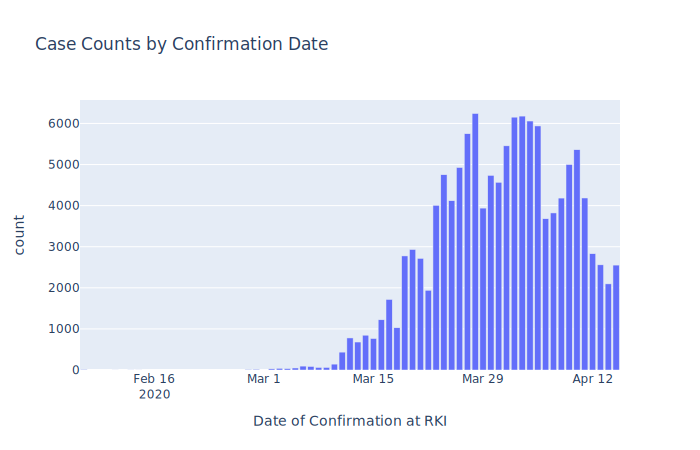

In [83]:
px.bar(confirmed, x='date_confirmation', y='count', title="Case Counts by Confirmation Date",labels=plotlabels)

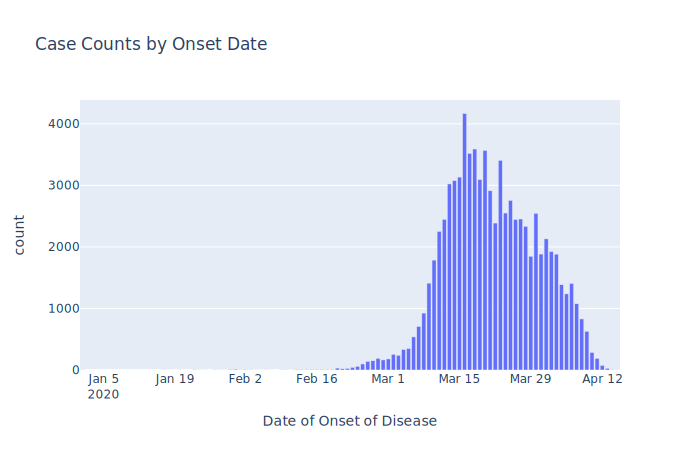

In [84]:
px.bar(onset, x='date_onset', y='count', title="Case Counts by Onset Date",labels=plotlabels)

#### Plot delay for one specific day

In [85]:
day="2020-03-28"
delay_conf_day = delay.query(f"date_confirmation == '{day}'")

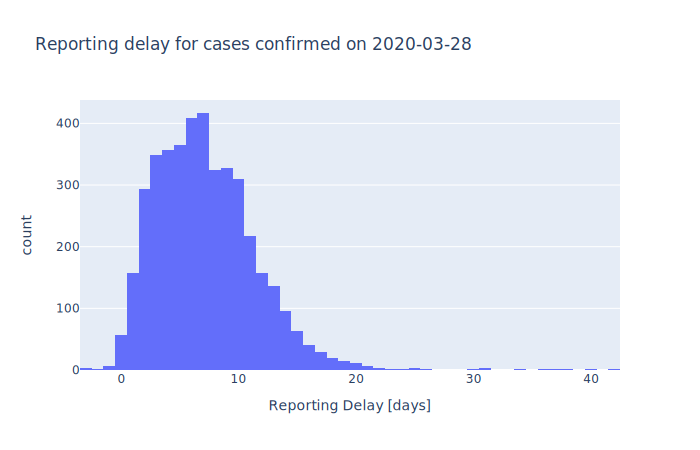

In [86]:
px.histogram(delay_conf_day, x='reporting_delay_hd', title=f"Reporting delay for cases confirmed on {day}",labels=plotlabels)

In [87]:
day="2020-03-10"
delay_onset_day = delay.query(f"date_onset == '{day}'")

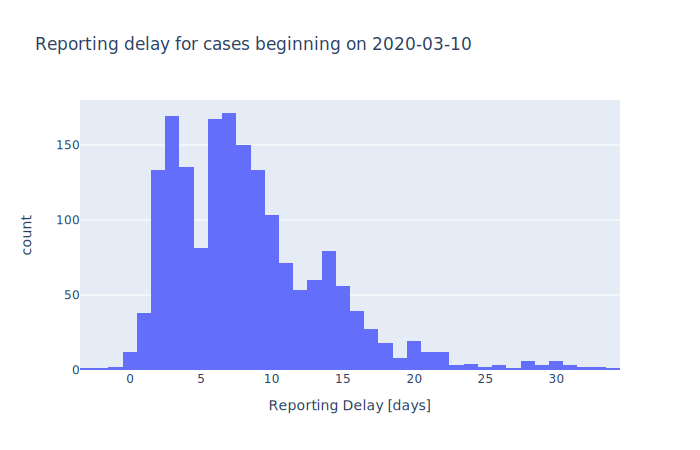

In [88]:
px.histogram(delay_onset_day, x='reporting_delay_hd', title=f"Reporting delay for cases beginning on {day}",labels=plotlabels)

#### Distribution of Delay by Day of the Week

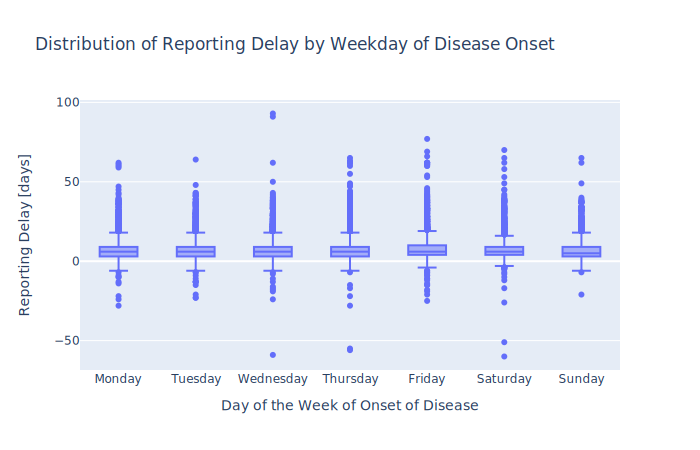

In [89]:
px.box(delay.query("date_confirmation>'2020-03-01'").sort_values("weekday_onset"), 
       y="reporting_delay_hd", x="weekday_onset", 
       title= "Distribution of Reporting Delay by Weekday of Disease Onset",
       labels=plotlabels).show()

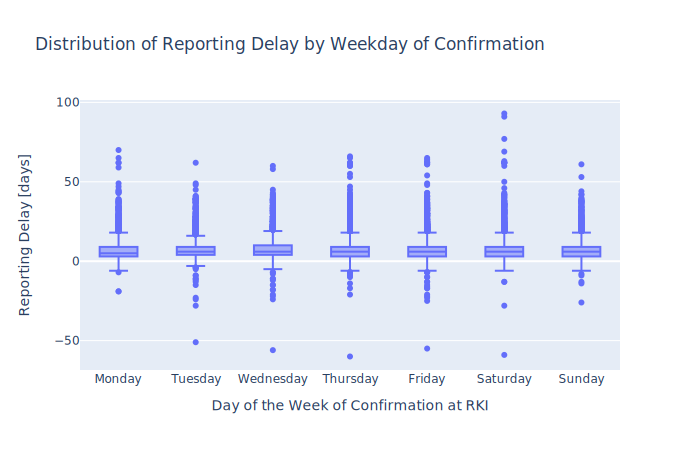

In [90]:
px.box(delay.query("date_confirmation>'2020-03-01'").sort_values("weekday_confirmation"), 
       y="reporting_delay_hd", x="weekday_confirmation", 
       title= "Distribution of Reporting Delay by Weekday of Confirmation",
       labels=plotlabels)

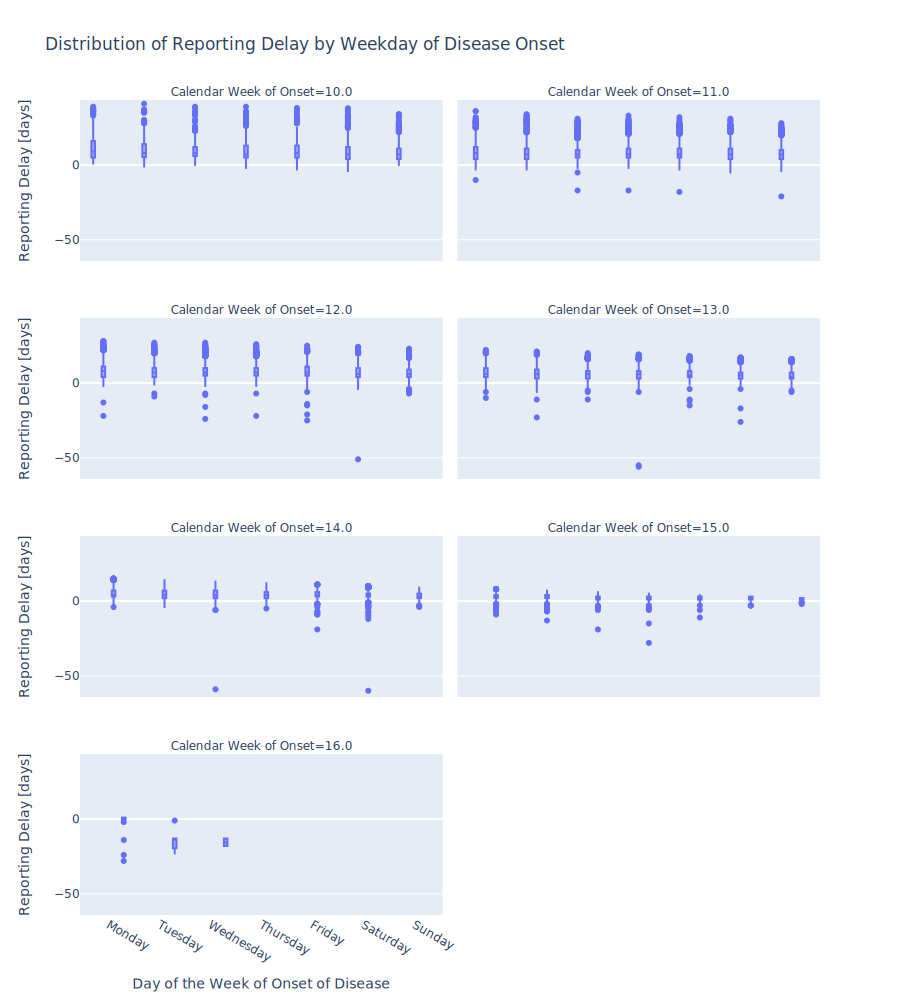

In [91]:
px.box(delay.query("date_onset>'2020-03-01'").sort_values(["week_onset","weekday_onset"]), 
       y="reporting_delay_hd", x="weekday_onset", 
       title= "Distribution of Reporting Delay by Weekday of Disease Onset", facet_col="week_onset",
       facet_col_wrap=2, height=1000, width=1000,
       labels=plotlabels).show(height=1000, width=900)

### Case counts per weekday

In [92]:
case_counts_weekly_avg = pd.merge(delay.groupby(["date_onset","week_onset","weekday_onset"]).size().reset_index().rename(columns={0:"day_count"}),
                       delay.groupby("week_onset").size().reset_index().rename(columns={0:"week_count"})
        ).assign(week_daily_average = lambda x: x.week_count/7,
                 week_deviation = lambda x: x.day_count/x.week_daily_average)

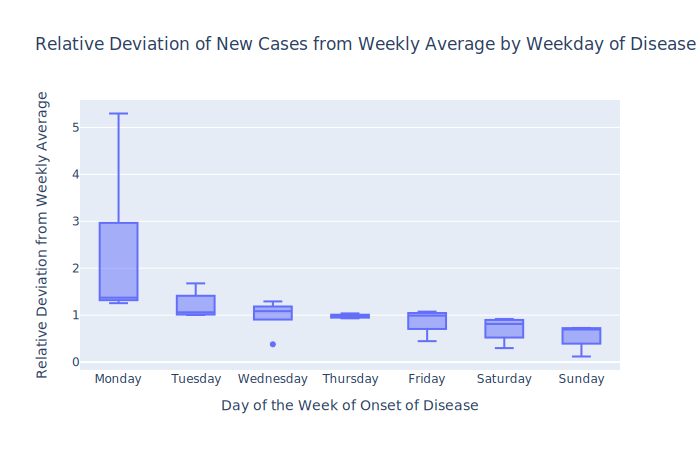

In [93]:
px.box(case_counts_weekly_avg.query("date_onset>'2020-03-15'"), 
       y="week_deviation", x="weekday_onset", 
       title= "Relative Deviation of New Cases from Weekly Average by Weekday of Disease Onset",
       labels=dict(week_deviation="Relative Deviation from Weekly Average",**plotlabels))

In [94]:
def as_ordered_weekday(col):
    return col.astype(pd.CategoricalDtype(ordered=True)).cat.reorder_categories(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        ordered=True,
    )

# case_counts_moving_avg
case_counts_moving_avg = delay.query("date_onset>='2020-03-01'").groupby(["date_onset"]).size().reindex(pd.date_range(
    delay["date_onset"].min(),delay["date_onset"].max()), fill_value=0).reset_index().rename(
    columns={0:"day_count","index":"date_onset"}).assign(day_count_ma=lambda x: x.day_count.rolling(window=7).mean()
 ).assign(ma_deviation = lambda x: x.day_count/x.day_count_ma,
          weekday_onset = lambda x: as_ordered_weekday(x.date_onset.dt.day_name()))

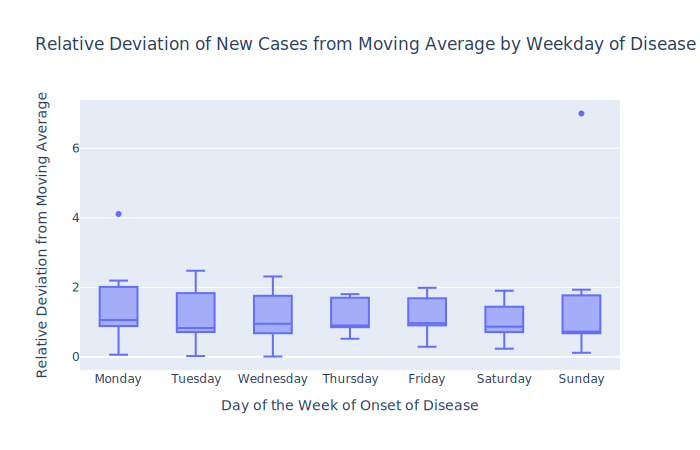

In [95]:
px.box(case_counts_moving_avg.sort_values("weekday_onset"), 
       y="ma_deviation", x="weekday_onset", 
       title= "Relative Deviation of New Cases from Moving Average by Weekday of Disease Onset",
       labels=dict(ma_deviation="Relative Deviation from Moving Average",**plotlabels))

In [96]:
# case_counts_moving_avg
case_counts_moving_avg = delay.query("date_onset>='2020-03-01'").groupby(["date_confirmation"]).size().reindex(pd.date_range(
    delay["date_confirmation"].min(),delay["date_confirmation"].max()), fill_value=0).reset_index().rename(
    columns={0:"day_count","index":"date_confirmation"}).assign(day_count_ma=lambda x: x.day_count.rolling(window=7).mean()
 ).assign(ma_deviation = lambda x: x.day_count/x.day_count_ma,
          weekday_confirmation = lambda x: as_ordered_weekday(x.date_confirmation.dt.day_name()))

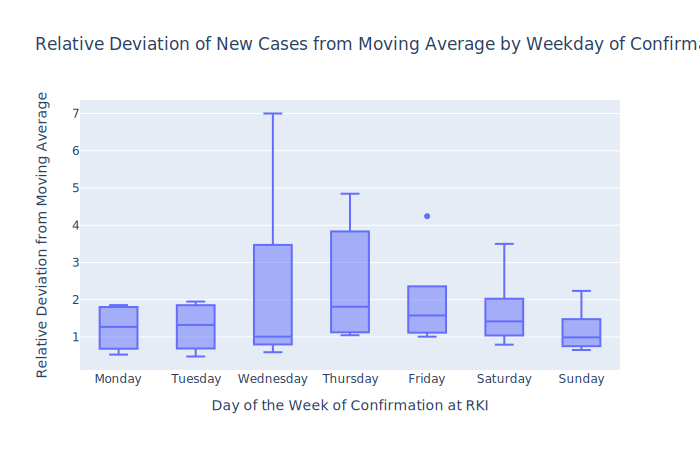

In [97]:
px.box(case_counts_moving_avg.sort_values("weekday_confirmation"), 
       y="ma_deviation", x="weekday_confirmation", 
       title= "Relative Deviation of New Cases from Moving Average by Weekday of Confirmation",
       labels=dict(ma_deviation="Relative Deviation from Moving Average",**plotlabels))

In [98]:
# case_counts_moving_avg
case_counts_moving_avg = delay.query("date_onset>='2020-03-01'").groupby(["date_report"]).size().reindex(pd.date_range(
    delay["date_report"].min(),delay["date_report"].max()), fill_value=0).reset_index().rename(
    columns={0:"day_count","index":"date_report"}).assign(day_count_ma=lambda x: x.day_count.rolling(window=7).mean()
 ).assign(ma_deviation = lambda x: x.day_count/x.day_count_ma,
          weekday_report = lambda x: as_ordered_weekday(x.date_report.dt.day_name()))

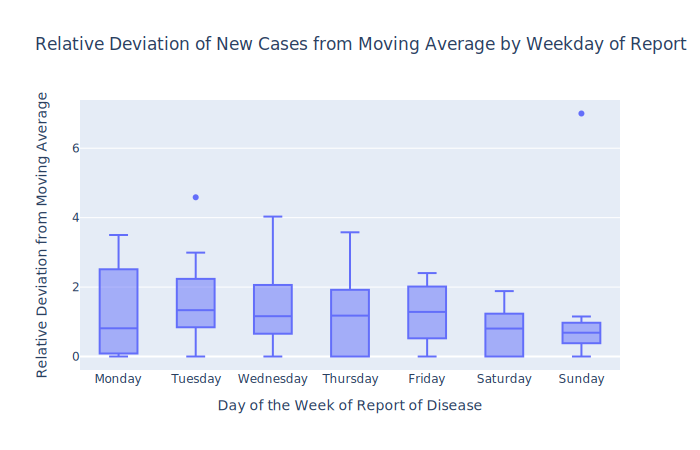

In [99]:
px.box(case_counts_moving_avg.sort_values("weekday_report"), 
       y="ma_deviation", x="weekday_report", 
       title= "Relative Deviation of New Cases from Moving Average by Weekday of Report",
       labels=dict(ma_deviation="Relative Deviation from Moving Average",**plotlabels))

#### Distribution of Delay over Time

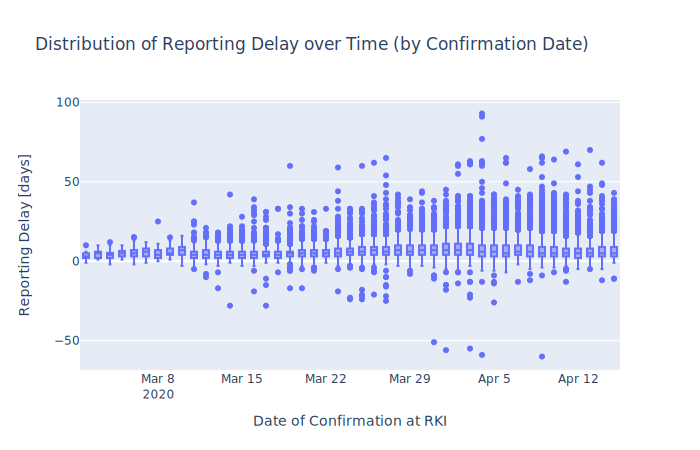

In [100]:
px.box(delay.query("date_confirmation>'2020-03-01'"), x="date_confirmation", y="reporting_delay_hd", title= "Distribution of Reporting Delay over Time (by Confirmation Date)",
       labels=plotlabels)

In [101]:
delay_agg = delay.query("date_onset>'2020-03-01'").groupby(
    ["date_confirmation"])["reporting_delay_rki"].describe(percentiles =[0.25,0.75])

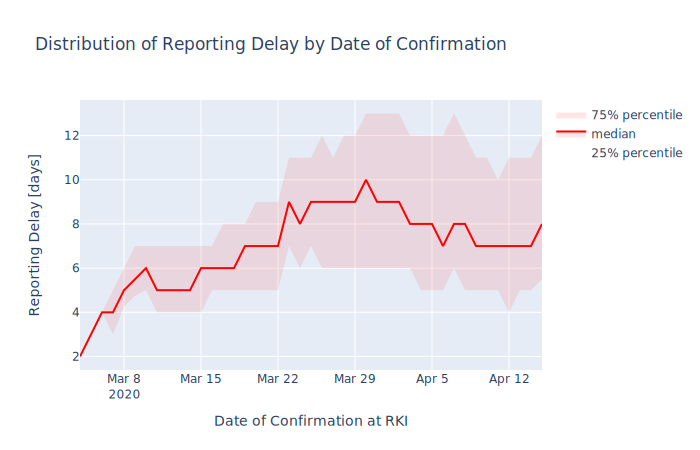

In [102]:
#px.box(delay.query("date_onset>'2020-03-01'"), x="date_confirmation", y="reporting_delay_hd", title= "Distribution of Reporting Delay over Time (by Confirmation Date)",
#       labels=plotlabels)



import plotly.graph_objects as go

fig = go.Figure()



fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["25%"],
    mode='lines',
        fill=None,
    line_color="rgba(0, 0, 0, 0)", showlegend=True, name="25% percentile"
))

fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["50%"],
    mode='lines', 
    line_color="red",
    name="median",
    fill='tonexty',
    fillcolor="rgba(255, 0, 0, 0.1)"
    ))


fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["75%"],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line_color="rgba(0, 0, 0, 0)",
    fillcolor="rgba(255, 0, 0, 0.1)",  showlegend=True, name="75% percentile"
))



fig.update_layout(title="Distribution of Reporting Delay by Date of Confirmation",xaxis=dict(title="Date of Confirmation at RKI"),yaxis=dict(title="Reporting Delay [days]"))

fig.show()

In [103]:
delay_agg = delay.query("reporting_delay_hd>=0 & date_report>'2020-03-01'").groupby(
    ["date_report"])["reporting_delay_hd"].describe(percentiles =[0.25,0.75])

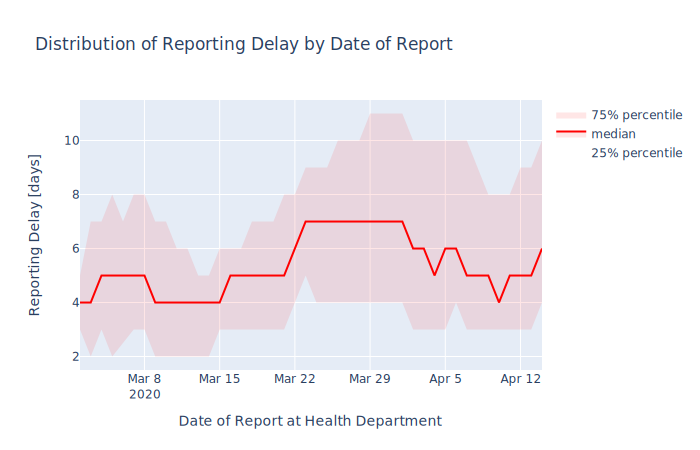

In [104]:
#px.box(delay.query("date_onset>'2020-03-01'"), x="date_confirmation", y="reporting_delay_hd", title= "Distribution of Reporting Delay over Time (by Confirmation Date)",
#       labels=plotlabels)


import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["25%"],
    mode='lines',
        fill=None,
    line_color="rgba(0, 0, 0, 0)", showlegend=True, name="25% percentile"
))

fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["50%"],
    mode='lines', 
    line_color="red",
    name="median",
    fill='tonexty',
    fillcolor="rgba(255, 0, 0, 0.1)"
    ))


fig.add_trace(go.Scatter(
    x=delay_agg.index,
    y=delay_agg["75%"],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line_color="rgba(0, 0, 0, 0)",
    fillcolor="rgba(255, 0, 0, 0.1)",  showlegend=True, name="75% percentile"
))


fig.update_layout(title="Distribution of Reporting Delay by Date of Report",xaxis=dict(title="Date of Report at Health Department"),yaxis=dict(title="Reporting Delay [days]"))

fig.show()

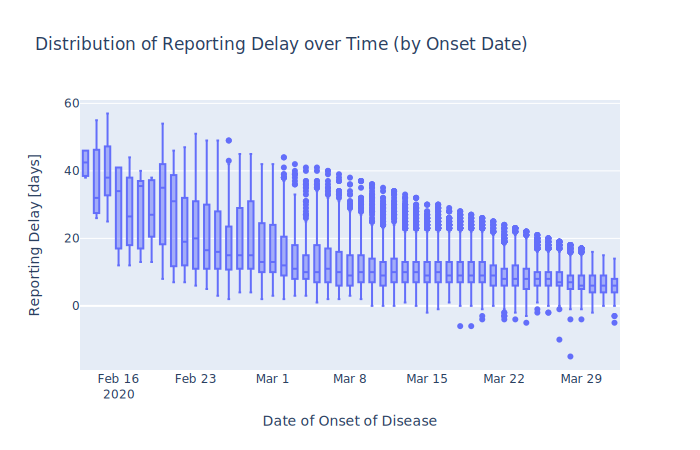

In [40]:
px.box(delay.query("date_onset>'2020-02-12'"), x="date_onset", y="reporting_delay_hd", title= "Distribution of Reporting Delay over Time (by Onset Date)",
       labels=plotlabels)

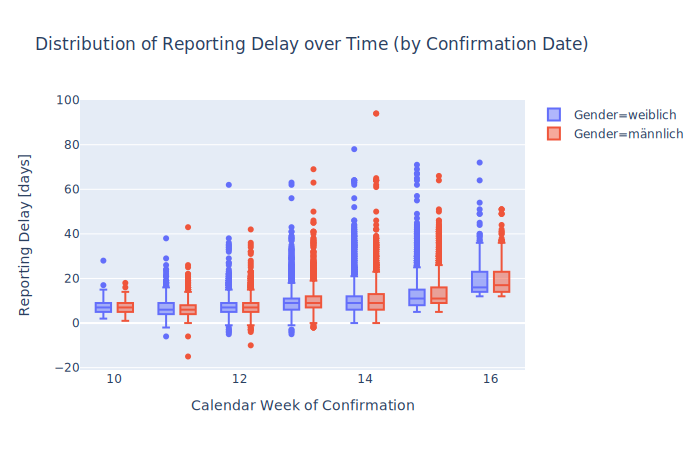

In [41]:
px.box(delay.query("date_confirmation>'2020-03-01'"), x="week_confirmation", y="reporting_delay_hd", color="gender" , title= "Distribution of Reporting Delay over Time (by Confirmation Date)",
       labels=plotlabels)

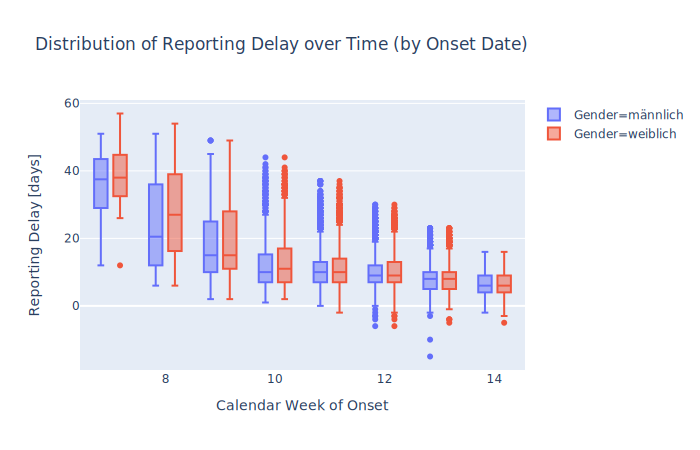

In [42]:
px.box(delay.query("date_onset>'2020-02-12'"), x="week_onset", y="reporting_delay_hd", color="gender", title= "Distribution of Reporting Delay over Time (by Onset Date)",
       labels=plotlabels).show()

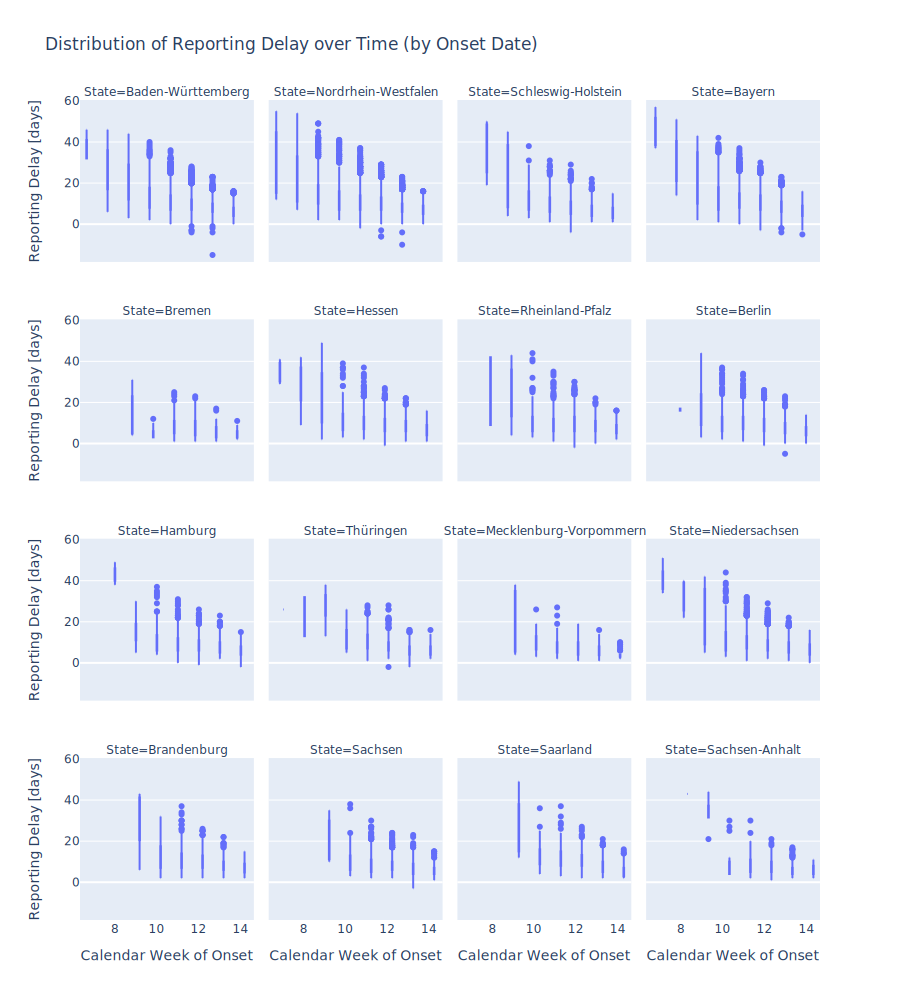

In [54]:
px.box(delay.query("date_onset>'2020-02-12'"), x="week_onset", facet_col="state",facet_col_wrap=4,
       y="reporting_delay_hd", title= "Distribution of Reporting Delay over Time (by Onset Date)", 
       labels=plotlabels).show(height=1000, width=900)